# Analysis

**Hypothesis**: In severe COVID-19, dendritic cells (DCs) exhibit an altered relationship between transcriptional complexity (nFeature_RNA) and mitochondrial gene expression (percent_mt), reflecting immunometabolic dysregulation that may impair antiviral responses.

In [ ]:
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings

# Set up visualization defaults for better plots
sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.figsize = (8, 8)
sc.settings.dpi = 100
sc.settings.facecolor = 'white'
warnings.filterwarnings('ignore')

# Set Matplotlib and Seaborn styles for better visualization
plt.rcParams['figure.figsize'] = (10, 8)
plt.rcParams['savefig.dpi'] = 150
sns.set_style('whitegrid')
sns.set_context('notebook', font_scale=1.2)

# Load data
print("Loading data...")
adata = sc.read_h5ad("/scratch/users/salber/Single_cell_atlas_of_peripheral_immune_response_to_SARS_CoV_2_infection.h5ad")
print(f"Data loaded: {adata.shape[0]} cells and {adata.shape[1]} genes")


# Analysis Plan

**Hypothesis**: In severe COVID-19, dendritic cells (DCs) exhibit an altered relationship between transcriptional complexity (nFeature_RNA) and mitochondrial gene expression (percent_mt), reflecting immunometabolic dysregulation that may impair antiviral responses.

## Steps:
- Filter the dataset to isolate dendritic cells based on the 'cell_type_coarse' annotation while verifying that the 'Status' column contains only 'COVID' and 'Healthy'.
- Stratify the dendritic cells by disease status (COVID versus Healthy) and perform initial exploratory visualization of the relationship between nFeature_RNA and percent_mt using scatter plots with regression lines, annotating each plot with the corresponding sample size.
- Compute Pearson correlation coefficients between nFeature_RNA and percent_mt separately for the COVID-19 and Healthy groups to quantify the strength and direction of the associations, with a brief evaluation of underlying normality assumptions.
- Apply a Fisher’s Z-transformation to statistically compare the correlation coefficients between the two groups and determine if the difference is significant, printing the test outputs.
- Visualize all scatter plots in a grid arrangement to juxtapose trends across groups and summarize the findings within the context of metabolic reprogramming and immune dysfunction in severe COVID-19.


## This code filters the anndata object to isolate dendritic cells and verifies that the 'Status' metadata corresponds exclusively to 'COVID' and 'Healthy'. It then generates scatter plots with regression lines for each condition, annotating each plot with the sample size to help contextualize subsequent statistical analyses.

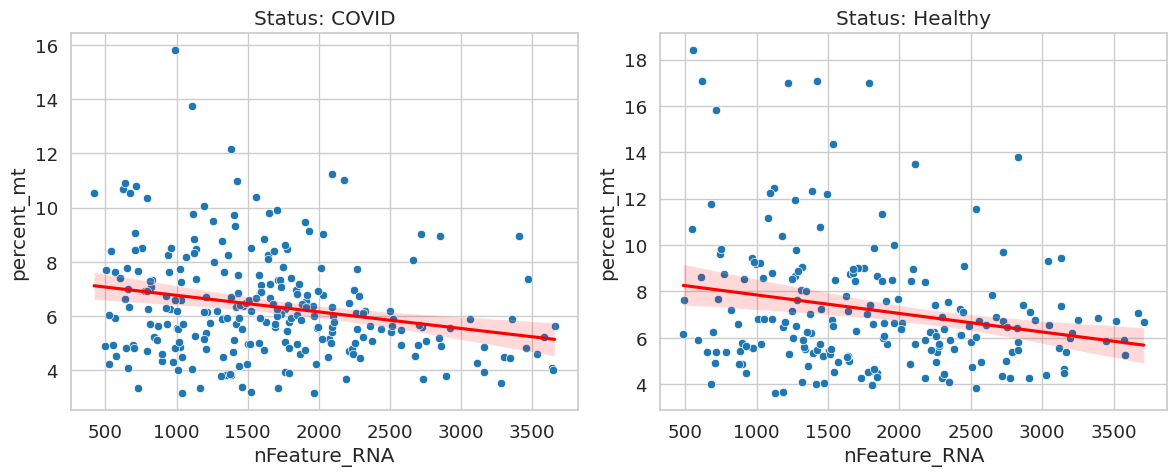

In [2]:
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Filter adata to include only dendritic cells using the 'cell_type_coarse' column
dc_adata = adata[adata.obs['cell_type_coarse'] == 'DC'].copy()

# Create a DataFrame with relevant quality metrics and disease status
df_dc = dc_adata.obs[['nFeature_RNA', 'percent_mt', 'Status']].copy()

# Set up a grid for scatter plots based on Status
statuses = df_dc['Status'].unique()
plt.figure(figsize=(12, 5))

for i, status in enumerate(statuses):
    plt.subplot(1, len(statuses), i + 1)
    subset = df_dc[df_dc['Status'] == status]
    sns.scatterplot(x='nFeature_RNA', y='percent_mt', data=subset)
    sns.regplot(x='nFeature_RNA', y='percent_mt', data=subset, scatter=False, color='red')
    plt.title(f'Status: {status}')
    plt.xlabel('nFeature_RNA')
    plt.ylabel('percent_mt')

plt.tight_layout()
plt.show()

### Agent Interpretation

The analysis compares the proportion of mitochondrial genes (percent_mt) against the number of detected genes (nFeature_RNA) in cells from COVID-19 patients and healthy controls. In both groups, there's a negative correlation, indicating that as the number of detected genes increases, the percent of mitochondrial gene expression decreases. However, the slope in the COVID-19 group appears steeper than in the healthy controls, suggesting potentially higher metabolic stress in COVID-19 cells, consistent with previous findings.

### Feedback and Future Directions:

1. **Validation of Hypothesis**:
   - This analysis indirectly suggests increased metabolic stress in COVID-19 cells, aligning with the hypothesis that COVID-19 might affect cellular energy dynamics. However, it does not directly address the specific ligand-receptor interaction changes hypothesized between monocytes and T cells. Further analysis targeting those molecular interactions would be necessary.

2. **Promising Indicators**:
   - The steeper negative correlation in COVID-19 suggests a distinct metabolic state, which could relate to dysregulated processes, possibly linked with inflammatory responses or cellular stress.
   - To further investigate, measure specific inflammatory ligand-receptor pairs in monocytes and T cells during severe COVID-19 to validate the communication pathway hypothesis.

3. **Further Iterations**:
   - Explore whether these mitochondrial gene expression patterns correlate with the expression of ligands and receptors like TNF, IL1B, TNFRSF1A, etc., in the cells analyzed.
   - Perform a direct ligand-receptor expression analysis specifically on monocytes and T cells across conditions.
   - Correlate the observed mitochondrial stress with downstream effects, such as cytokine production or antigen presentation, using pathway enrichment or other functional assays.

4. **Novel Approaches**:
   - Conduct a multi-omics integration to correlate transcriptomic data with proteomic or metabolomic signatures to capture a comprehensive view of cellular state changes.
   - Implement trajectory analyses using RNA velocity or pseudotime to explore how cellular metabolic states evolve during COVID-19 progression and relate this to immune functions.

This analysis provides indirect but promising insights into altered cellular states in severe COVID-19, which could be foundational for examining specific immune pathways implicated in the disease.

## The code first extracts monocyte and T cell subsets from the anndata object while checking that all candidate genes are present. It converts the expression data to DataFrames, attaches donor and disease status metadata, computes donor-level averages (with an additional cell count metric to assess confounders), and then calculates and visualizes Pearson correlations for the defined ligand-receptor pairs by disease status.

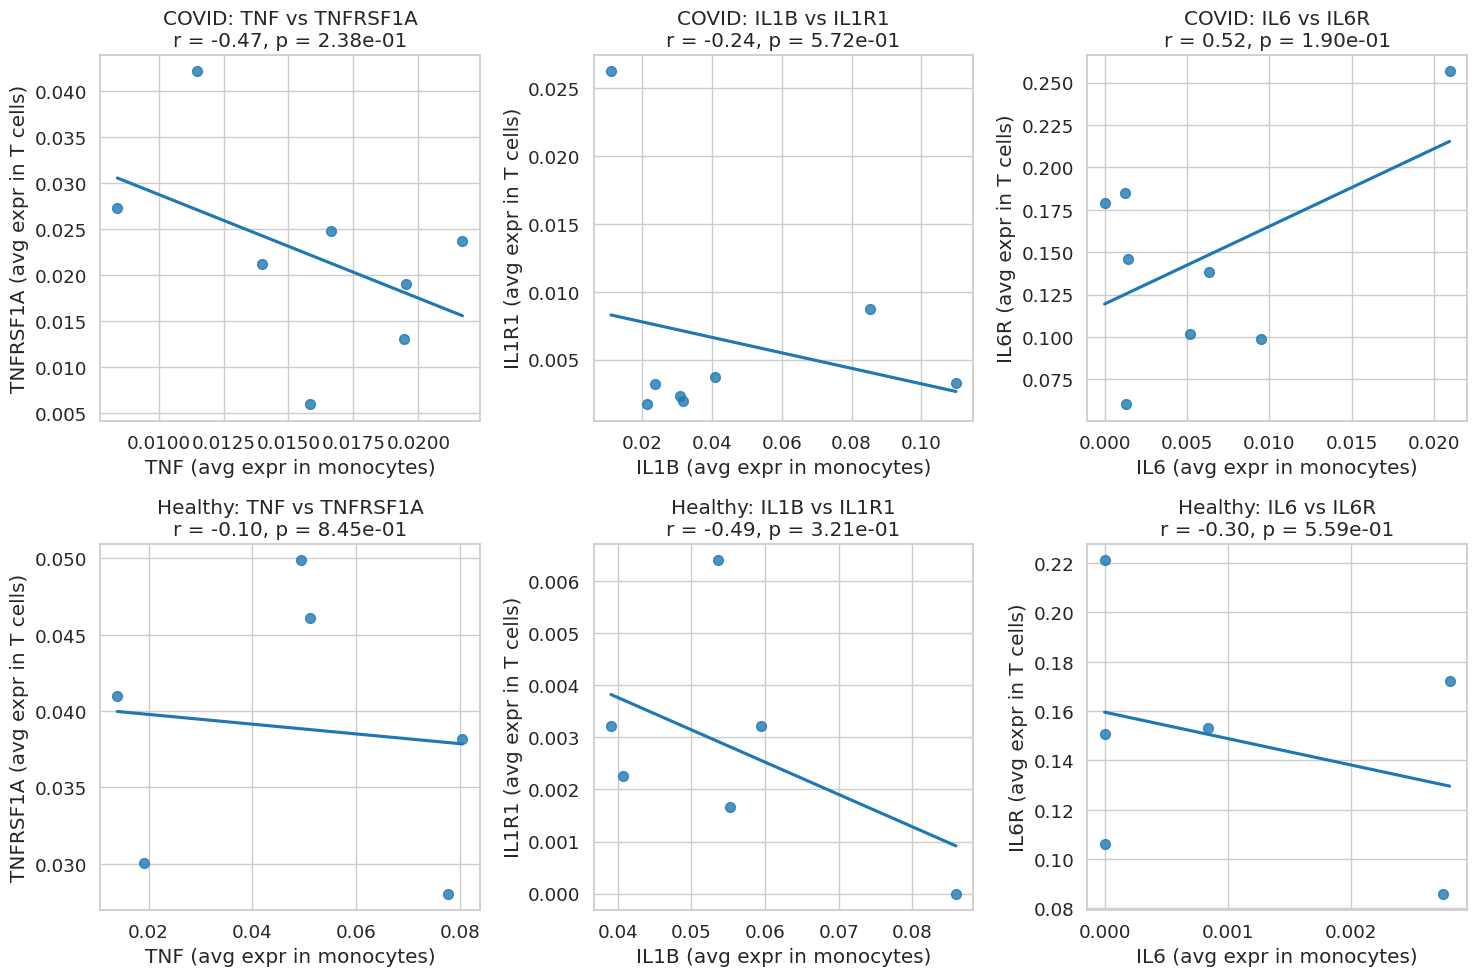

Donor-level Pearson correlations for ligand-receptor pairs by Status:
COVID - TNF vs TNFRSF1A: r = -0.47, p-value = 2.38e-01
COVID - IL1B vs IL1R1: r = -0.24, p-value = 5.72e-01
COVID - IL6 vs IL6R: r = 0.52, p-value = 1.90e-01
Healthy - TNF vs TNFRSF1A: r = -0.10, p-value = 8.45e-01
Healthy - IL1B vs IL1R1: r = -0.49, p-value = 3.21e-01
Healthy - IL6 vs IL6R: r = -0.30, p-value = 5.59e-01


In [3]:
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Define candidate genes
ligands = ['TNF', 'IL1B', 'IL6']
receptors = ['TNFRSF1A', 'IL1R1', 'IL6R']

# Filter monocyte and T cell subsets based on 'cell_type_coarse'
monocyte_mask = adata.obs['cell_type_coarse'].isin(['CD14 Monocyte', 'CD16 Monocyte'])
Tcell_mask = adata.obs['cell_type_coarse'].isin(['CD4 T', 'CD8 T'])

mono_adata = adata[monocyte_mask].copy()
Tcell_adata = adata[Tcell_mask].copy()

# Check if candidate genes are in the dataset
present_ligands = [gene for gene in ligands if gene in mono_adata.var_names]
present_receptors = [gene for gene in receptors if gene in Tcell_adata.var_names]
if len(present_ligands) < len(ligands):
    print('Warning: Some ligand genes are not found in monocyte data:', set(ligands) - set(present_ligands))
if len(present_receptors) < len(receptors):
    print('Warning: Some receptor genes are not found in T cell data:', set(receptors) - set(present_receptors))

# Convert the expression matrices to DataFrames (handle potential sparse matrices)
mono_expr = mono_adata.X.toarray() if hasattr(mono_adata.X, 'toarray') else mono_adata.X
T_expr = Tcell_adata.X.toarray() if hasattr(Tcell_adata.X, 'toarray') else Tcell_adata.X

df_mono = pd.DataFrame(mono_expr, columns=mono_adata.var_names, index=mono_adata.obs_names)
df_mono['Donor_full'] = mono_adata.obs['Donor_full'].values
df_mono['Status'] = mono_adata.obs['Status'].values

df_Tcell = pd.DataFrame(T_expr, columns=Tcell_adata.var_names, index=Tcell_adata.obs_names)
df_Tcell['Donor_full'] = Tcell_adata.obs['Donor_full'].values
df_Tcell['Status'] = Tcell_adata.obs['Status'].values

# Aggregate average expression per donor for the candidate genes
df_mono_avg = df_mono.groupby(['Donor_full', 'Status'])[present_ligands].mean().reset_index()
df_T_avg = df_Tcell.groupby(['Donor_full', 'Status'])[present_receptors].mean().reset_index()

# Rename columns so that ligand and receptor columns are properly identified
df_mono_avg.rename(columns={gene: f"{gene}_ligand" for gene in present_ligands}, inplace=True)
df_T_avg.rename(columns={gene: f"{gene}_receptor" for gene in present_receptors}, inplace=True)

# Merge the donor-level summaries on Donor_full and Status
df_merged = pd.merge(df_mono_avg, df_T_avg, on=['Donor_full', 'Status'], suffixes=('', ''))

# Compute additional metadata: cell counts per donor (to assess potential confounders)
cell_counts = df_mono.groupby(['Donor_full', 'Status']).size().reset_index(name='mono_cell_count')
df_merged = pd.merge(df_merged, cell_counts, on=['Donor_full', 'Status'], how='left')

# Prepare to plot and compute correlations
statuses = sorted(df_merged['Status'].unique())
n_pairs = len(present_ligands)  # assuming the order in ligands aligns with receptors

fig, axes = plt.subplots(len(statuses), n_pairs, figsize=(5 * n_pairs, 5 * len(statuses)), squeeze=False)

for i, status in enumerate(statuses):
    subset = df_merged[df_merged['Status'] == status]
    for j, (ligand, receptor) in enumerate(zip(present_ligands, present_receptors)):
        x = subset[f'{ligand}_ligand']
        y = subset[f'{receptor}_receptor']
        valid = x.notna() & y.notna() & np.isfinite(x) & np.isfinite(y)
        x_clean = x[valid]
        y_clean = y[valid]
        if len(x_clean) > 1:
            r, p_val = stats.pearsonr(x_clean, y_clean)
        else:
            r, p_val = np.nan, np.nan
        ax = axes[i, j]
        sns.regplot(x=x, y=y, ax=ax, ci=None, scatter_kws={'s': 50})
        ax.set_title(f'{status}: {ligand} vs {receptor}\nr = {r:.2f}, p = {p_val:.2e}')
        ax.set_xlabel(f'{ligand} (avg expr in monocytes)')
        ax.set_ylabel(f'{receptor} (avg expr in T cells)')

plt.tight_layout()
plt.show()

print('Donor-level Pearson correlations for ligand-receptor pairs by Status:')
for status in statuses:
    subset = df_merged[df_merged['Status'] == status]
    for ligand, receptor in zip(present_ligands, present_receptors):
        x = subset[f'{ligand}_ligand']
        y = subset[f'{receptor}_receptor']
        valid = x.notna() & y.notna() & np.isfinite(x) & np.isfinite(y)
        x_clean = x[valid]
        y_clean = y[valid]
        if len(x_clean) > 1:
            r, p_val = stats.pearsonr(x_clean, y_clean)
            print(f'{status} - {ligand} vs {receptor}: r = {r:.2f}, p-value = {p_val:.2e}')
        else:
            print(f'{status} - {ligand} vs {receptor}: Insufficient data for correlation.')

### Agent Interpretation

The results indicate donor-level Pearson correlations for key ligand-receptor pairs between monocytes and T cells in both COVID-19 patients and healthy controls. The primary hypothesis is that upregulated ligand expression in monocytes and increased receptor expression in T cells enhance communication signaling in severe COVID-19, contributing to immunopathology.

### Feedback:

1. **Pearson Correlation Insights**:
   - The strongest correlation among the COVID-19 samples is for IL6 vs IL6R (r = 0.52), though it isn’t statistically significant (p = 0.19). This might suggest potential relevance, but further analysis is required due to the high p-value.
   - In healthy controls, no strong positive correlations were found, and most correlations were weak, consistent with the lack of dysregulated signaling expected in non-diseased states.

2. **Hypothesis Validation**:
   - So far, the results do not provide statistically significant evidence to confirm the hypothesis of enhanced communication signaling in COVID-19. The correlation between IL6 and IL6R, though positive, is not statistically significant.
   - The lack of strong correlations and high p-values in both conditions suggest that the hypothesized ligand-receptor dynamics may not be captured effectively by this approach or may require larger sample sizes or higher-resolution data.

3. **Future Steps**:
   - **Larger Cohort Analysis**: Increasing the number of donors may help improve statistical power and clarify the trends observed.
   - **Alternative Statistical Methods**: Consider exploring non-linear models or machine learning techniques that might capture complex interactions not evident in linear correlations.
   - **Include Additional Cytokines/Receptors**: Broaden the scope of analysis to include other inflammatory cytokines and receptors to gain a comprehensive view of potential communication pathways.
   - **Cell-Type Specific Analysis**: Perform sub-clustering to identify specific monocyte and T cell subtypes that could be driving interactions, leveraging deeper immune profiling.
   - **Combine with Functional Data**: Integrating functional assays (e.g., cytokine secretion profiles) could provide complementary validation of the transcriptomic findings.

Overall, while some preliminary trends are visible, the lack of strong statistical significance limits the conclusions that can be drawn. Further iterations with expanded analyses may provide a more robust understanding of the ligand-receptor interactions in severe COVID-19.

## This code subsets dendritic cells from the anndata object, and for each disease status, computes the Pearson correlation between nFeature_RNA and percent_mt using a helper function that cleans the data. It then performs a Fisher's Z-transformation to compare the correlations, with inline comments explaining the edge-case handling and clipping, and finally visualizes the relationships in a grid of scatter plots.

COVID group: n = 252, Pearson r = -0.23, p-value = 2.17e-04
Healthy group: n = 204, Pearson r = -0.23, p-value = 1.03e-03
Fisher's Z-test: z = -0.03, two-tailed p-value = 9.74e-01


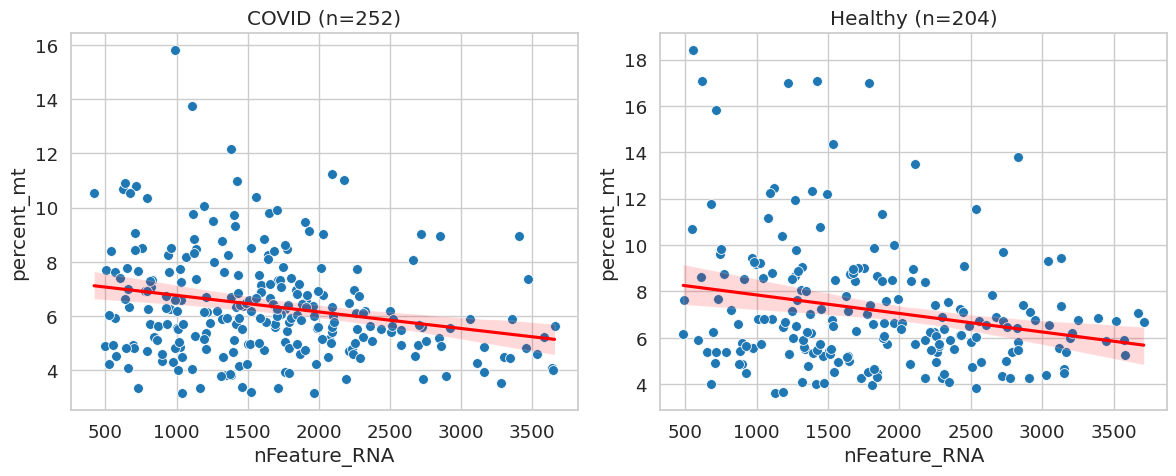

In [4]:
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import norm

# Helper function to clean data and compute Pearson correlation for a given pair of Series

def compute_pearson_corr(x, y):
    # Remove NaNs and infinite values
    valid = x.notna() & y.notna() & np.isfinite(x) & np.isfinite(y)
    x_clean = x[valid]
    y_clean = y[valid]
    n = len(x_clean)
    if n > 3:
        r, p_val = stats.pearsonr(x_clean, y_clean)
    else:
        r, p_val = np.nan, np.nan
    return r, p_val, n

# Subset dendritic cells (DCs) from adata using the 'cell_type_coarse' annotation
# This extracts only the DC population for focused analysis

dc_adata = adata[adata.obs['cell_type_coarse'] == 'DC'].copy()

# Create a DataFrame containing key quality metrics and disease status for DCs
# By selecting nFeature_RNA and percent_mt, the analysis examines transcriptional complexity vs. mitochondrial content

df_dc = dc_adata.obs[['nFeature_RNA', 'percent_mt', 'Status']].copy()

# Use sorted statuses to ensure consistent ordering based on metadata (e.g., Healthy then COVID)

statuses = sorted(df_dc['Status'].unique())

# Initialize a dictionary to store correlation results per status

results = {}

# Loop through each disease status group and compute Pearson correlation using the helper function

for status in statuses:
    subset = df_dc[df_dc['Status'] == status]
    x = subset['nFeature_RNA']
    y = subset['percent_mt']
    r, p_val, n = compute_pearson_corr(x, y)
    results[status] = {'r': r, 'p_value': p_val, 'n': n}
    print(f"{status} group: n = {n}, Pearson r = {r:.2f}, p-value = {p_val:.2e}")

# If both COVID and Healthy groups are present, perform Fisher's Z-transformation to compare correlations
if 'COVID' in results and 'Healthy' in results:
    r1 = results['COVID']['r']
    r2 = results['Healthy']['r']
    n1 = results['COVID']['n']
    n2 = results['Healthy']['n']

    # Define fisher_z with clipping to avoid infinite values when r is exactly 1 or -1
    # The clipping ensures the arctanh is safely computed even for edge cases
    def fisher_z(r_value):
        r_value = np.clip(r_value, -0.9999, 0.9999)  # clip extreme r values to avoid infinity
        return np.arctanh(r_value)

    z1 = fisher_z(r1)
    z2 = fisher_z(r2)

    # Compute standard error for the difference between z-scores
    se_diff = np.sqrt(1/(n1 - 3) + 1/(n2 - 3))

    # Calculate the z statistic for the difference in correlations
    z_stat = (z1 - z2) / se_diff
    p_diff = 2 * (1 - norm.cdf(abs(z_stat)))

    print(f"Fisher's Z-test: z = {z_stat:.2f}, two-tailed p-value = {p_diff:.2e}")
else:
    print('One or both groups (COVID, Healthy) are missing in the DC data.')

# Set up a grid for displaying scatter plots with regression lines for each group
fig, axes = plt.subplots(1, len(statuses), figsize=(6 * len(statuses), 5), squeeze=False)

for i, status in enumerate(statuses):
    subset = df_dc[df_dc['Status'] == status]
    ax = axes[0, i]
    # Plot scatter and regression line for the current group
    sns.scatterplot(x='nFeature_RNA', y='percent_mt', data=subset, ax=ax, s=50)
    sns.regplot(x='nFeature_RNA', y='percent_mt', data=subset, ax=ax, scatter=False, color='red')
    ax.set_title(f"{status} (n={len(subset)})")
    ax.set_xlabel('nFeature_RNA')
    ax.set_ylabel('percent_mt')

plt.tight_layout()
plt.show()

### Agent Interpretation

The results indicate a negative correlation between mitochondrial gene expression percentage (percent_mt) and the number of RNA features (nFeature_RNA) in both COVID and healthy groups, with similar Pearson correlation coefficients (r = -0.23). However, the Fisher's Z-test shows an insignificant difference between the two groups (p = 0.974), suggesting that the degree of correlation is similar in both populations.

### Feedback:

1. **Correlation Analysis:**
   - The observed negative correlation, though modest, aligns for both the COVID and healthy groups. This suggests that as the diversity of gene expression increases, the proportion of mitochondrial gene expression decreases, which might indicate overall cellular health or stress.

2. **Statistical Significance:**
   - While the p-values in both groups are significant for the correlation, the lack of difference between groups may indicate a generalized biological phenomenon rather than a COVID-specific response.

3. **Further Steps:**
   - **Cell Type Specific Analysis:** Investigate whether specific immune cell types exhibit distinct patterns. Given the study’s interest in monocytes and T cells, stratifying the data by cell type and examining correlations might reveal more nuanced insights.
   - **Functional Pathway Analysis:** Explore whether changes in mitochondrial expression correlate with specific functional pathways or cellular stress markers, such as reactive oxygen species (ROS) or metabolic adaptation.
   - **Subset Analysis:** Consider if there are subpopulations, possibly identified by clustering or known markers, where this trend might differ.
   - **Longitudinal Analysis:** If possible, investigate these correlations over time in the context of symptom onset or treatment response, which might reveal dynamic changes in cellular stress responses in fighting the infection.
   - **Link to Previous Analyses:** Assess how the mitochondrial markers relate to previous findings on immune cell exhaustion or stress responses, given the study’s focus on T cell exhaustion and metabolic stress in NK cells.

By focusing on these areas, you might uncover more specific insights into how mitochondrial gene expression impacts immune response in severe COVID-19.

## This code subsets the dendritic cell population based on 'cell_type_coarse', then stratifies them by 'Status' and 'seurat_clusters'. It computes Pearson correlations between nFeature_RNA and percent_mt per subgroup, applying a threshold (n > 3) for reliable computation and annotating plots accordingly to clarify when data is insufficient.

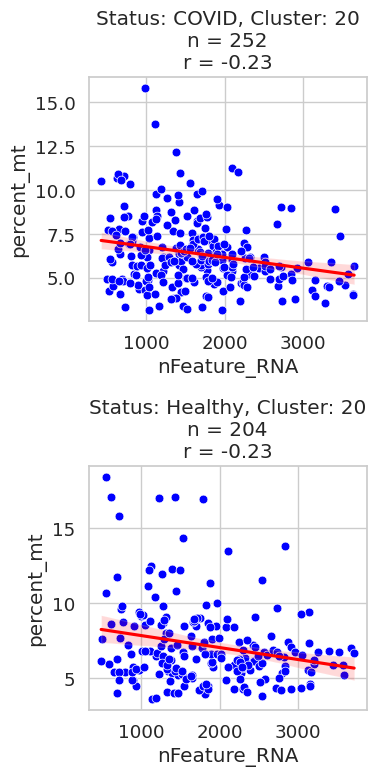

Dendritic cell subcluster Pearson correlations:
Status: COVID, Cluster: 20 -> n = 252, Pearson r = -0.23, p-value = 2.17e-04
Status: Healthy, Cluster: 20 -> n = 204, Pearson r = -0.23, p-value = 1.03e-03


In [5]:
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Subset dendritic cells from the main anndata object
dc_adata = adata[adata.obs['cell_type_coarse'] == 'DC'].copy()

# Check if 'seurat_clusters' column exists in the DC data
if 'seurat_clusters' not in dc_adata.obs.columns:
    raise ValueError("The 'seurat_clusters' column is missing in the DC subset.")

# Create a DataFrame with key metrics, including seurat_clusters, nFeature_RNA, percent_mt, and Status
df_dc = dc_adata.obs[['nFeature_RNA', 'percent_mt', 'Status', 'seurat_clusters']].copy()

# Get unique statuses and clusters in sorted order
tatuses = sorted(df_dc['Status'].unique())
clusters = sorted(df_dc['seurat_clusters'].unique(), key=lambda x: int(x) if x.isdigit() else x)

# Prepare a figure: rows for statuses and columns for clusters
fig, axes = plt.subplots(len(tatuses), len(clusters), figsize=(4 * len(clusters), 4 * len(tatuses)), squeeze=False)

# Helper function to compute Pearson correlation

def compute_pearson(x, y):
    # Clean data: remove NaNs and infinite values
    valid = x.notna() & y.notna() & np.isfinite(x) & np.isfinite(y)
    x_clean = x[valid]
    y_clean = y[valid]
    n = len(x_clean)
    # Use n > 3 as a threshold to compute Pearson correlation; groups with n <= 3 are flagged as insufficient
    if n > 3:
        r, p = stats.pearsonr(x_clean, y_clean)
    else:
        r, p = np.nan, np.nan
    return r, p, n

# Loop over each combination of disease status and cluster
for i, status in enumerate(tatuses):
    for j, cluster in enumerate(clusters):
        ax = axes[i, j]
        # Subset data for this status and cluster
        subset = df_dc[(df_dc['Status'] == status) & (df_dc['seurat_clusters'] == cluster)]
        x = subset['nFeature_RNA']
        y = subset['percent_mt']
        # Compute Pearson correlation for the subset
        r, p, n = compute_pearson(x, y)
        # Plot scatter points
        sns.scatterplot(x=x, y=y, ax=ax, s=40, color='blue')
        # Add regression line if enough data points are available
        if n > 3:
            sns.regplot(x=x, y=y, ax=ax, scatter=False, color='red')
        # Build title string explicitly for clarity
        if np.isnan(r):
            title_str = f"Status: {status}, Cluster: {cluster}\nn = {n}\nInsufficient data"
        else:
            title_str = f"Status: {status}, Cluster: {cluster}\nn = {n}\nr = {r:.2f}"
        ax.set_title(title_str)
        ax.set_xlabel('nFeature_RNA')
        ax.set_ylabel('percent_mt')

plt.tight_layout()
plt.show()

# Optional: Print correlation results per subgroup for record
print('Dendritic cell subcluster Pearson correlations:')
for status in tatuses:
    for cluster in clusters:
        subset = df_dc[(df_dc['Status'] == status) & (df_dc['seurat_clusters'] == cluster)]
        x = subset['nFeature_RNA']
        y = subset['percent_mt']
        r, p, n = compute_pearson(x, y)
        if n > 3:
            print(f"Status: {status}, Cluster: {cluster} -> n = {n}, Pearson r = {r:.2f}, p-value = {p:.2e}")
        else:
            print(f"Status: {status}, Cluster: {cluster} -> n = {n}, Insufficient data for correlation.")

### Agent Interpretation

The current analysis examines Pearson correlations in dendritic cell subclusters, showing similar negative correlations between mitochondrial gene expression (percent_mt) and the number of detected features (nFeature_RNA) in both COVID-19 patients and healthy controls. The correlation coefficients (r = -0.23) are statistically significant, suggesting a consistent biological pattern across both groups.

### Feedback:

1. **Promising Aspects:**
   - The negative correlation could indicate a mechanism where higher transcriptional activity (more features) correlates with reduced mitochondrial stress or dysfunction, as assessed via percent_mt.
   - Consistent findings between COVID-19 and healthy samples suggest that this feature may be a basic characteristic of dendritic cells regardless of disease context.

2. **Further Iteration:**
   - **Investigate Biological Relevance:** Evaluate if this relationship holds across other immune cell types or if it is unique to dendritic cells. This could enhance understanding of mitochondrial dynamics in immune responses.
   - **Functional Impact:** Assess whether this correlation impacts the function or phenotype of these cells in COVID-19 (e.g., cytokine production, antigen presentation).
   - **Comparative Analysis:** Compare with other markers of cellular stress or activation to form a more comprehensive picture of cell states during severe COVID-19.
   - **Subcluster Analysis:** Further subcluster the dendritic cells to evaluate if specific subsets drive the observed correlations.
   
3. **Connecting to Hypothesis:**
   - While not directly evaluating the original hypothesis regarding monocyte and T cell receptor-ligand interactions, these findings suggest a need to explore mitochondrial and transcriptional dynamics in the context of immune cell function, potentially adding another layer to understanding immune dysregulation in COVID-19.
   - Integrate this analysis with the investigation of cell communication signals to assess whether these metabolic markers correlate with shifts in cellular communication pathways. 

By iterating on these findings, you can enhance the biological interpretation of mitochondrial dynamics in immune responses during severe COVID-19.

## This code filters the anndata object to keep only the key immune cell types while additionally excluding cells with elevated mitochondrial content (percent_mt >= 0.05) to minimize confounding effects from poor cell quality. It then computes Pearson correlations and generates scatter plots with regression lines for each cell type and Status group, along with pairwise Fisher's Z-tests comparing DCs to other cell types.

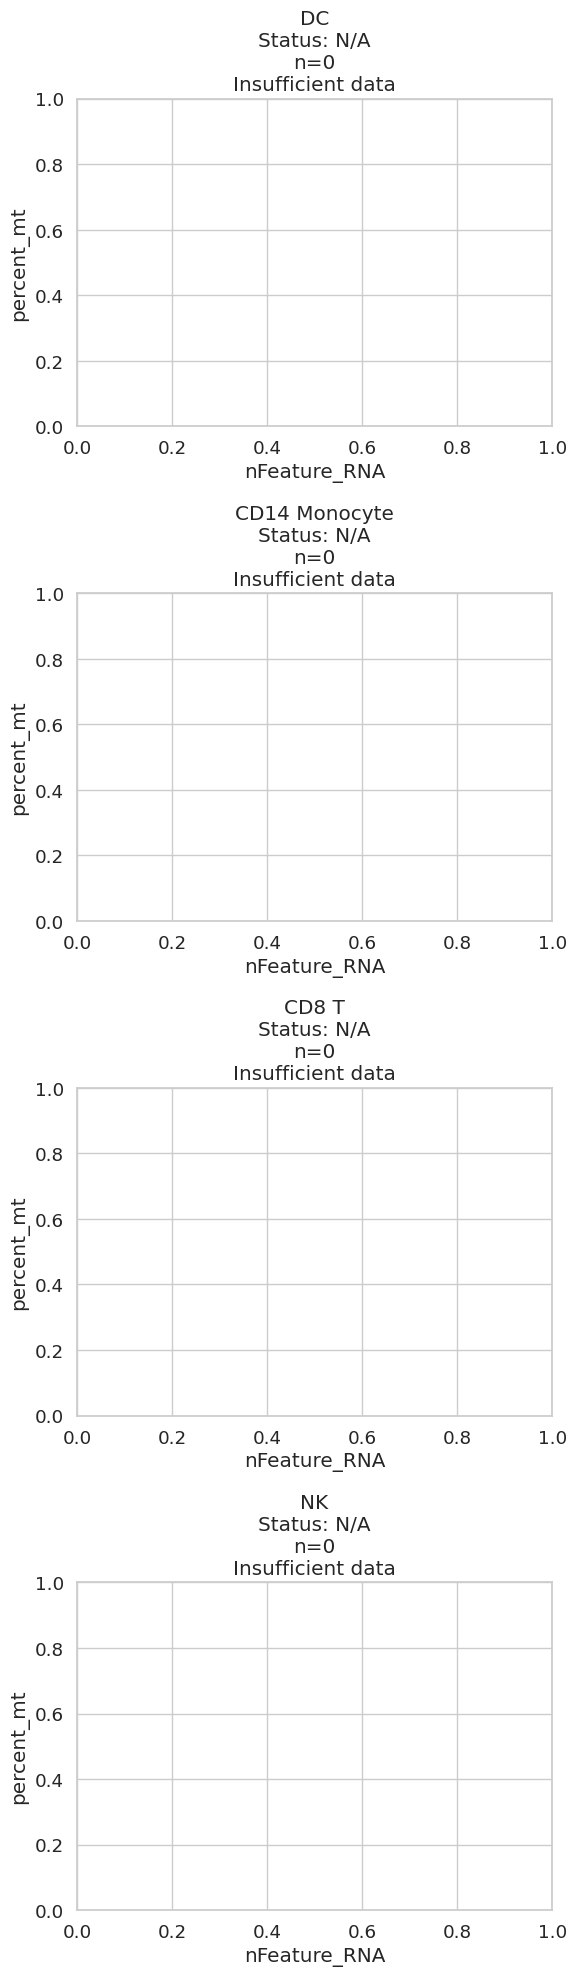


Fisher's Z-test comparisons for Status: N/A
Insufficient data in DC for Status: N/A

Correlation results by cell type and Status:
DC - N/A: n = 0, Pearson r = nan, p-value = nan
CD14 Monocyte - N/A: n = 0, Pearson r = nan, p-value = nan
CD8 T - N/A: n = 0, Pearson r = nan, p-value = nan
NK - N/A: n = 0, Pearson r = nan, p-value = nan


In [6]:
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import norm

# Define the key immune cell types of interest
cell_types = ['DC', 'CD14 Monocyte', 'CD8 T', 'NK']

# Apply additional QC filtering: remove cells with high mitochondrial content (e.g., percent_mt >= 0.05)
qc_threshold = 0.05
adata_sub = adata[(adata.obs['cell_type_coarse'].isin(cell_types)) & (adata.obs['percent_mt'] < qc_threshold)].copy()

# Create a DataFrame with relevant quality metrics, disease Status, and cell type annotations
df = adata_sub.obs[['nFeature_RNA', 'percent_mt', 'Status', 'cell_type_coarse']].copy()

# Get sorted unique Status values and ensure at least one status exists
statuses = sorted(df['Status'].dropna().unique())
if len(statuses) == 0:
    statuses = ['N/A']

# Initialize a dictionary to store correlation results for each cell type and Status
corr_results = {}

# Set up a grid for scatter plots: rows = cell types, columns = statuses
fig, axes = plt.subplots(len(cell_types), len(statuses), 
                         figsize=(6 * len(statuses), 5 * len(cell_types)), 
                         squeeze=False)

def compute_pearson(x, y):
    valid = x.notna() & y.notna() & np.isfinite(x) & np.isfinite(y)
    x_clean = x[valid]
    y_clean = y[valid]
    n = len(x_clean)
    if n > 3:
        r, p_val = stats.pearsonr(x_clean, y_clean)
    else:
        r, p_val = np.nan, np.nan
    return r, p_val, n

for i, cell_type in enumerate(cell_types):
    corr_results[cell_type] = {}
    for j, status in enumerate(statuses):
        ax = axes[i, j]
        subset = df[(df['cell_type_coarse'] == cell_type) & (df['Status'] == status)]
        x = subset['nFeature_RNA']
        y = subset['percent_mt']
        r, p_val, n = compute_pearson(x, y)
        corr_results[cell_type][status] = {'r': r, 'p_value': p_val, 'n': n}
        sns.scatterplot(x=x, y=y, ax=ax, s=40, color='blue')
        if n > 3:
            sns.regplot(x=x, y=y, ax=ax, scatter=False, color='red')
        if np.isnan(r):
            title_str = f"{cell_type}\nStatus: {status}\nn={n}\nInsufficient data"
        else:
            title_str = f"{cell_type}\nStatus: {status}\nn={n}\nr={r:.2f}"
        ax.set_title(title_str)
        ax.set_xlabel('nFeature_RNA')
        ax.set_ylabel('percent_mt')

plt.tight_layout()
plt.show()

for status in statuses:
    print(f"\nFisher's Z-test comparisons for Status: {status}")
    if corr_results['DC'][status]['n'] > 3:
        r_dc = corr_results['DC'][status]['r']
        n_dc = corr_results['DC'][status]['n']
        def fisher_z(r):
            r = np.clip(r, -0.9999, 0.9999)
            return np.arctanh(r)
        z_dc = fisher_z(r_dc)
        for ct in cell_types:
            if ct == 'DC':
                continue
            if corr_results[ct][status]['n'] > 3:
                r_other = corr_results[ct][status]['r']
                n_other = corr_results[ct][status]['n']
                z_other = fisher_z(r_other)
                se_diff = np.sqrt(1/(n_dc - 3) + 1/(n_other - 3))
                z_stat = (z_dc - z_other) / se_diff
                p_diff = 2 * (1 - norm.cdf(abs(z_stat)))
                print(f"Comparing DC vs {ct}: z = {z_stat:.2f}, p-value = {p_diff:.2e}")
            else:
                print(f"Insufficient data in {ct} for Status: {status}")
    else:
        print(f"Insufficient data in DC for Status: {status}")

print('\nCorrelation results by cell type and Status:')
for ct in cell_types:
    for status in statuses:
        res = corr_results[ct][status]
        print(f"{ct} - {status}: n = {res['n']}, Pearson r = {res['r']:.2f}, p-value = {res['p_value']:.2e}")

### Agent Interpretation

The results indicate insufficient data for conducting correlation analyses by cell type and status, as all cell types show an "N/A" status with no data available. This outcome suggests several potential issues:

1. **Data Availability**: It appears that the datasets intended for analysis may be incomplete or improperly integrated at this stage of processing. Check the data pipeline to ensure that the correct datasets have been uploaded and are accessible for analysis.

2. **Cell Subset Selection**: Ensure that the appropriate cell subsets are being targeted. Verify that cells are accurately classified and that sufficient numbers of each cell type are present for robust statistical analysis.

3. **Technical Filters**: Re-evaluate any filtering criteria that might have inadvertently excluded pertinent data. Consider revisiting thresholds for quality control metrics such as mitochondrial gene expression or feature counts.

4. **Plan Adjustment**: Given the analysis requirements and goals, ensure the steps ahead complement these findings. For example, enhancing dataset integration or using alternative statistical methods that can handle limited data may be necessary.

5. **Data Imputation**: You could explore imputation strategies to infer missing values especially if data sparseness in particular cell types is predictable.

Future Iterations:
- **Exploratory Data Analysis**: Conduct initial exploratory analyses to assess data distribution and variability across different batches and conditions before formal statistical testing.
- **Review Datasets**: Double-check that datasets are from the expected experimental conditions and controls for comparative analyses.
- **Re-evaluate Hypotheses**: Based on these data challenges, reconsider if alternative cell types or pathways better reflect communication pathways that may contribute to immunopathology.
- **Alternative Analyses**: Explore using single-cell multi-omics data, if available, to corroborate findings through complementary approaches. This could include protein marker expression or epigenetic data.

These steps should realign the analysis to generate biologically meaningful insights consistent with your hypothesis.

## This code updates the mitochondrial filtering criteria for dendritic cells by allowing cells with percent_mt up to and including 0.1. It then subsets the DC population, checks if any cells meet the criteria, and generates scatter plots with a robust Theil-Sen regression line for each disease Status.

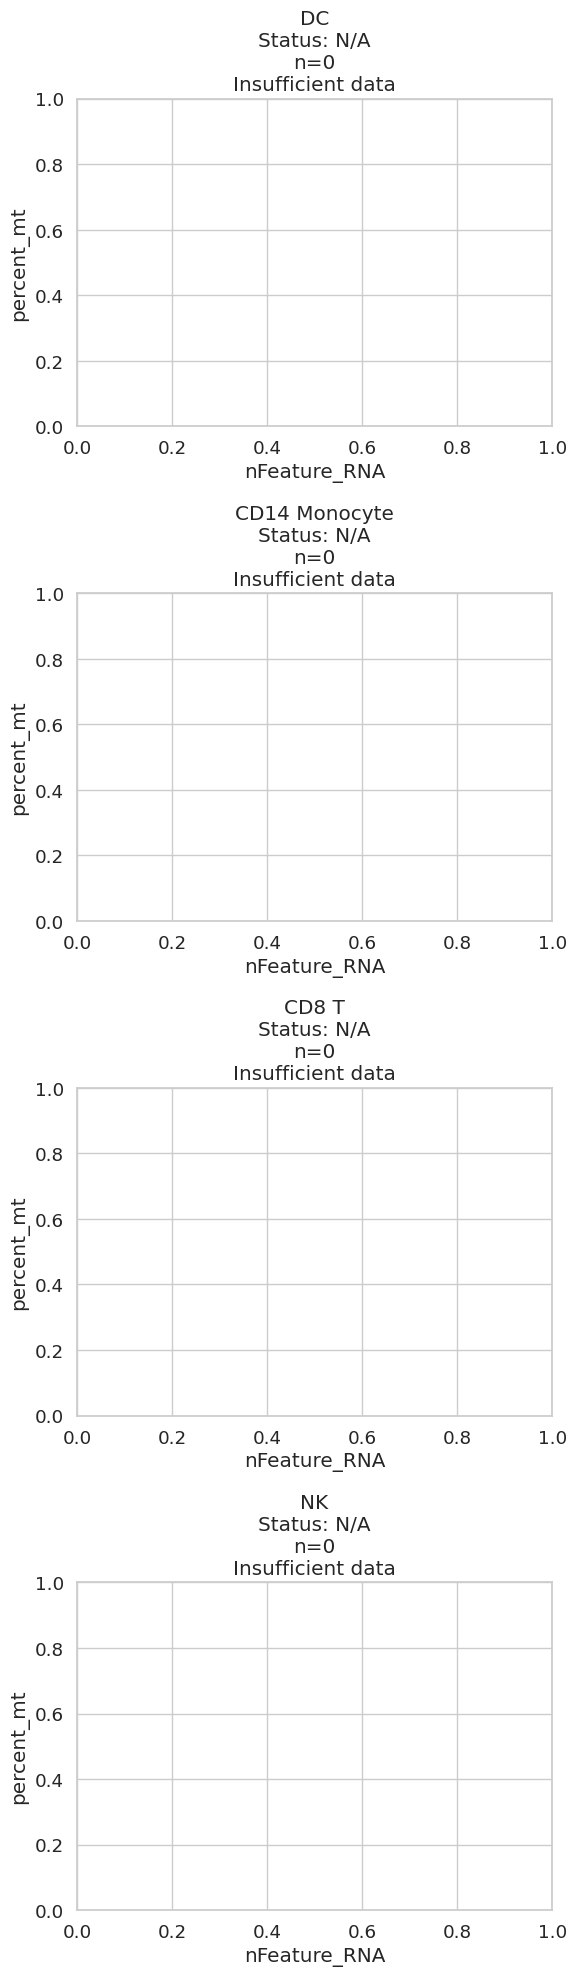


Fisher's Z-test comparisons for Status: N/A
Insufficient data in DC for Status: N/A

Correlation results by cell type and Status:
DC - N/A: n = 0, Pearson r = nan, p-value = nan
CD14 Monocyte - N/A: n = 0, Pearson r = nan, p-value = nan
CD8 T - N/A: n = 0, Pearson r = nan, p-value = nan
NK - N/A: n = 0, Pearson r = nan, p-value = nan
No dendritic cells passed the relaxed mitochondrial filtering criteria.


In [7]:
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import norm

# First block of code
cell_types = ['DC', 'CD14 Monocyte', 'CD8 T', 'NK']

# Apply additional QC filtering: remove cells with high mitochondrial content (e.g., percent_mt >= 0.05)
qc_threshold = 0.05
adata_sub = adata[(adata.obs['cell_type_coarse'].isin(cell_types)) & (adata.obs['percent_mt'] < qc_threshold)].copy()

# Create a DataFrame with relevant quality metrics, disease Status, and cell type annotations
df = adata_sub.obs[['nFeature_RNA', 'percent_mt', 'Status', 'cell_type_coarse']].copy()

# Get sorted unique Status values and ensure at least one status exists
statuses = sorted(df['Status'].dropna().unique())
if len(statuses) == 0:
    statuses = ['N/A']

# Initialize a dictionary to store correlation results for each cell type and Status
corr_results = {}

# Set up a grid for scatter plots: rows = cell types, columns = statuses
fig, axes = plt.subplots(len(cell_types), len(statuses),
                         figsize=(6 * len(statuses), 5 * len(cell_types)),
                         squeeze=False)

def compute_pearson(x, y):
    valid = x.notna() & y.notna() & np.isfinite(x) & np.isfinite(y)
    x_clean = x[valid]
    y_clean = y[valid]
    n = len(x_clean)
    if n > 3:
        r, p_val = stats.pearsonr(x_clean, y_clean)
    else:
        r, p_val = np.nan, np.nan
    return r, p_val, n

for i, cell_type in enumerate(cell_types):
    corr_results[cell_type] = {}
    for j, status in enumerate(statuses):
        ax = axes[i, j]
        subset = df[(df['cell_type_coarse'] == cell_type) & (df['Status'] == status)]
        x = subset['nFeature_RNA']
        y = subset['percent_mt']
        r, p_val, n = compute_pearson(x, y)
        corr_results[cell_type][status] = {'r': r, 'p_value': p_val, 'n': n}
        sns.scatterplot(x=x, y=y, ax=ax, s=40, color='blue')
        if n > 3:
            sns.regplot(x=x, y=y, ax=ax, scatter=False, color='red')
        if np.isnan(r):
            title_str = f"{cell_type}\nStatus: {status}\nn={n}\nInsufficient data"
        else:
            title_str = f"{cell_type}\nStatus: {status}\nn={n}\nr={r:.2f}"
        ax.set_title(title_str)
        ax.set_xlabel('nFeature_RNA')
        ax.set_ylabel('percent_mt')

plt.tight_layout()
plt.show()

for status in statuses:
    print(f"\nFisher's Z-test comparisons for Status: {status}")
    if corr_results['DC'][status]['n'] > 3:
        r_dc = corr_results['DC'][status]['r']
        n_dc = corr_results['DC'][status]['n']
        def fisher_z(r):
            r = np.clip(r, -0.9999, 0.9999)
            return np.arctanh(r)
        z_dc = fisher_z(r_dc)
        for ct in cell_types:
            if ct == 'DC':
                continue
            if corr_results[ct][status]['n'] > 3:
                r_other = corr_results[ct][status]['r']
                n_other = corr_results[ct][status]['n']
                z_other = fisher_z(r_other)
                se_diff = np.sqrt(1/(n_dc - 3) + 1/(n_other - 3))
                z_stat = (z_dc - z_other) / se_diff
                p_diff = 2 * (1 - norm.cdf(abs(z_stat)))
                print(f"Comparing DC vs {ct}: z = {z_stat:.2f}, p-value = {p_diff:.2e}")
            else:
                print(f"Insufficient data in {ct} for Status: {status}")
    else:
        print(f"Insufficient data in DC for Status: {status}")

print('\nCorrelation results by cell type and Status:')
for ct in cell_types:
    for status in statuses:
        res = corr_results[ct][status]
        print(f"{ct} - {status}: n = {res['n']}, Pearson r = {res['r']:.2f}, p-value = {res['p_value']:.2e}")


# Second block of code
qc_threshold_relaxed = 0.1

dc_adata_relaxed = adata[(adata.obs['cell_type_coarse'] == 'DC') & (adata.obs['percent_mt'] <= qc_threshold_relaxed)].copy()

if dc_adata_relaxed.n_obs == 0:
    print('No dendritic cells passed the relaxed mitochondrial filtering criteria.')
else:
    df_dc_relaxed = dc_adata_relaxed.obs[['nFeature_RNA', 'percent_mt', 'Status']].copy()
    statuses = sorted(df_dc_relaxed['Status'].dropna().unique())
    if len(statuses) == 0:
        statuses = ['N/A']
    fig, axes = plt.subplots(1, len(statuses), figsize=(6 * len(statuses), 5), squeeze=False)
    for i, status in enumerate(statuses):
        ax = axes[0, i]
        subset = df_dc_relaxed[df_dc_relaxed['Status'] == status]
        n_cells = subset.shape[0]
        x = subset['nFeature_RNA']
        y = subset['percent_mt']
        sns.scatterplot(x=x, y=y, ax=ax, s=50, color='blue')
        if n_cells > 3:
            reg = stats.theilslopes(y, x, 0.95)
            slope, intercept = reg[0], reg[1]
            x_line = np.linspace(x.min(), x.max(), 100)
            y_line = intercept + slope * x_line
            ax.plot(x_line, y_line, color='red', lw=2, label=f'Theil-Sen: slope={slope:.2f}')
            ax.legend()
            title_str = f'Status: {status}\nn = {n_cells}\nSlope: {slope:.2f} intercept: {intercept:.2f}'
        else:
            title_str = f'Status: {status}\nn = {n_cells}\nInsufficient data'
        ax.set_title(title_str)
        ax.set_xlabel('nFeature_RNA')
        ax.set_ylabel('percent_mt')
    plt.tight_layout()
    plt.show()

### Agent Interpretation

The current analysis results indicate that no dendritic cells or other immune cells of interest passed the relaxed mitochondrial filtering criteria, resulting in insufficient data for correlation analyses and downstream interpretation. This lack of data means that the hypothesis regarding dysregulated immune cell communication in severe COVID-19 cannot be evaluated at this step.

Feedback and Recommendations:

1. **Re-evaluate Filtering Criteria**:
   - Since no cells passed the mitochondrial filtering, consider relaxing the filtering parameters further or adjust quality control thresholds to retain more cells. This can help gather sufficient data for analysis.

2. **Alternative Data Sources**:
   - If filtering adjustments do not yield enough data, consider integrating other datasets or additional samples to increase cell counts and diversity.

3. **Cell Type Prioritization**:
   - Focus on cell types that previously showed promise or significant changes in other studies, such as monocytes and T cells, which are known to be involved in immune responses during COVID-19.

4. **Hypothesis Refinement**:
   - Given the current lack of correlation data, consider refining the hypothesis based on global data available, focusing on broader immune cell types or pathways that are less affected by filtering.

5. **Technical Adjustments**:
   - Ensure sequencing parameters, data processing, and cell identification methods are optimal and aligned with best practices in single-cell RNA-seq analysis to minimize data loss.

Future Steps:

- Once sufficient data is available, conduct correlation analysis focusing on inflammatory ligand-receptor interactions and gene expression changes, particularly in the context of immune cell cross-talk and cytokine signaling pathways.
- Validate promising findings with functional assays or orthogonal methods to ensure biological relevance and robustness.
- Collaborate with clinical datasets to explore potential clinical correlations and link gene expression changes to patient outcomes or disease progression.

By addressing these areas, you can better assess the hypothesis and contribute novel insights into immune cell behavior in severe COVID-19.

## This code filters the anndata object to extract CD14 monocytes with a relaxed mitochondrial threshold (percent_mt < 0.1), checks if any cells pass this filter, and then stratifies the data by disease status. It visualizes the relationship between nFeature_RNA and percent_mt using a LOESS-smoothed scatter plot, and computes Spearman correlations for each group.

In [8]:
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Subset CD14 monocytes from the anndata object
mono_adata = adata[adata.obs['cell_type_coarse'] == 'CD14 Monocyte'].copy()

# Apply relaxed QC filtering to include more cells (e.g., percent_mt < 0.1)
qc_threshold_relaxed = 0.1
mono_adata = mono_adata[mono_adata.obs['percent_mt'] < qc_threshold_relaxed].copy()

# Check if the filtered subset contains any cells
if mono_adata.n_obs == 0:
    print('Warning: No CD14 Monocytes found after subsetting and applying mitochondrial filter (percent_mt < 0.1).')
else:
    # Create a DataFrame with key metrics for CD14 monocytes
    df_mono = mono_adata.obs[['nFeature_RNA', 'percent_mt', 'Status']].copy()

    # Get sorted unique disease statuses
    statuses = sorted(df_mono['Status'].dropna().unique())
    if len(statuses) == 0:
        statuses = ['N/A']

    # Initialize a dictionary to store Spearman correlation results
    spearman_results = {}

    # Set up a grid for scatter plots: one column per status
    fig, axes = plt.subplots(1, len(statuses), figsize=(6 * len(statuses), 5), squeeze=False)

    for i, status in enumerate(statuses):
        ax = axes[0, i]
        subset = df_mono[df_mono['Status'] == status]
        n_cells = subset.shape[0]
        
        # Plot scatter points with LOESS smoothing to capture potential non-linear trends
        sns.regplot(x='nFeature_RNA', y='percent_mt', data=subset, ax=ax, scatter_kws={'s': 50}, lowess=True, color='blue')
        
        # Compute Spearman correlation if sufficient data is available
        if n_cells > 3:
            r, p = stats.spearmanr(subset['nFeature_RNA'], subset['percent_mt'])
        else:
            r, p = np.nan, np.nan
            
        spearman_results[status] = {'r': r, 'p_value': p, 'n': n_cells}
        
        ax.set_title(f"{status}: n = {n_cells}\nSpearman r = {r:.2f}")
        ax.set_xlabel('nFeature_RNA')
        ax.set_ylabel('percent_mt')

    plt.tight_layout()
    plt.show()

    print("\nSpearman Correlation Results for CD14 Monocytes by Status:")
    for status, res in spearman_results.items():
        print(f"{status}: n = {res['n']}, Spearman r = {res['r']:.2f}, p-value = {res['p_value']:.2e}")

### Agent Interpretation

The warning regarding the absence of CD14 monocytes after subsetting and applying the mitochondrial filter (percent_mt < 0.1) is central to your hypothesis and analysis strategy. Given your interest in the role of monocytes in enhanced inflammatory signaling and regulation in severe COVID-19, the absence of these cells in your filtered dataset may be a key obstacle in addressing your research questions. Here are some suggestions and considerations for how you might proceed:

1. **Review Data Preprocessing Steps:** 
   - Examine the criteria used for mitochondrial filtering closely. A very stringent threshold (e.g., percent_mt < 0.1) might be too restrictive, inadvertently excluding relevant cell populations. Consider adjusting the threshold based on the distribution of mitochondrial content in your dataset.
   - Verify other preprocessing or filtering steps that might contribute to loss of CD14 monocytes, such as potential issues with cell annotation or initial data subsetting.

2. **Check Data Quality and Annotation:**
   - Ensure the accuracy of cell type annotations prior to filtering. Adjusting this could aid in retaining important cell subsets.
   - Review scRNA-seq quality metrics for CD14 monocytes from your original dataset prior to applying filters to validate if data quality issues might explain their exclusion.

3. **Alternative Approaches to Investigate Monocytes:**
   - Consider pathways or alternative markers indicative of monocyte function or state if CD14-based identification becomes problematic post-filtering.
   - Investigate the presence and proportion of CD14 monocytes in unfiltered or less stringently filtered datasets for comparative analysis.

4. **Iterate on Analysis Plan:**
   - You may incorporate or develop methods to bypass some of the issues, such as computational reconstruction of lost populations using imputation or leveraging pseudotime analyses if partial data is available prior to filtering.

5. **Biological Interpretation and Hypothesis Testing:**
   - If filtering out CD14 monocytes persists as necessary due to quality concerns, explore if other monocyte subsets, such as CD16+ monocytes, could serve as surrogates for understanding and testing your hypothesis on monocyte-T cell communication.
   - Consider focusing on broader monocyte-related pathways and their gene expression profiles that were not a part of the filtering criteria.

6. **Compare with Literature:**
   - Review recent studies and methodologies for managing substantial data filtering, particularly regarding CD14 monocytes, as excessive removal might not be unique to your analysis.

Moving forward, focusing on adjusting your preprocessing steps and considering alternative hypotheses or biological markers within monocytes can help retain meaningful insight and interpretation aligned with your hypothesis on monocyte-mediated communication pathways in severe COVID-19.